In [3]:
%pip install spacy
!python -m spacy download es_core_news_md

Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/42.3 MB ? eta -:--:--
     ---------------------------------------- 0.3/42.3 MB ? eta -:--:--
      --------------------------------------- 0.8/42.3 MB 2.6 MB/s eta 0:00:17
     - -------------------------------------- 1.3/42.3 MB 2.6 MB/s eta 0:00:16
     - -------------------------------------- 2.1/42.3 MB 2.9 MB/s eta 0:00:15
     -- ------------------------------------- 2.9/42.3 MB 2.9 MB/s eta 0:00:14
     --- ------------------------------------ 3.4/42.3 MB 3.0 MB/s eta 0:00:13
     --- ------------------------------------ 4.2/42.3 MB 3.1 MB/s eta 0:00:13
     ---- ----------------------------------- 4.7/42.3 MB 3.1 MB/s eta 0:00:13
     ----- ---------------------------------- 5.5/42.3 MB 3.1 MB/s eta 0:00:12
     ----- ---------------------------------- 6.0/42.3 MB 3.0 MB/s eta 0:00:12
     ----- ---------------------------------- 6.3/42.3 MB 3.1 MB/s eta 0:00:12


## 1. Carga de los datos

In [5]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
from tqdm import tqdm
import spacy
from sklearn.preprocessing import LabelEncoder
from keras._tf_keras.keras.preprocessing.text import one_hot
nlp = spacy.load("es_core_news_md")

splits = {'train': 'train.csv', 'validation': 'validation.csv'}
trainning_df = pd.read_csv("hf://datasets/Ernesto-1997/Sarcastic_spanish_dataset/" + splits["train"])
validation_df = pd.read_csv("hf://datasets/Ernesto-1997/Sarcastic_spanish_dataset/" + splits["validation"])

print('Número de Comentarios de entrenamiento Cargados: {num}'.format(num=trainning_df.shape[0]))
print('Número de Comentarios de validación Cargados: {num}'.format(num=validation_df.shape[0]))

trainning_comentarios = [list(x) for x in trainning_df[['Texto', 'Sarcasmo']].values]
validation_comentarios = [list(x) for x in validation_df[['Texto', 'Sarcasmo']].values]

c:\Users\LAGD\Documents\UCAB\10mo Semestre\IA\Proyectos\Proyecto2_IA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Número de Comentarios de entrenamiento Cargados: 15276
Número de Comentarios de validación Cargados: 3820


## 2. Normalización y tokenización de los datos

Para procesar los comentarios o textos de una forma acorde y generalizada, debemos pasar las mismas por un proceso de normalización y tokenización. 

> Normalización: En este proceso nos encargamos de "limpiar" el texto. Quitamos los signos de puntuación y convertimos la palabra a su raíz o lema.

> Tokenización: Cada frase la tratamos como un conjunto de tokens o palabras (en este caso). Posteriormente tomaremos un conjunto de palabras que formarán una secuencia de tokens


In [22]:
nlp = spacy.load('es_core_news_md')

def normalize(comentarios, min_word=5):

    comentarios_list = []
    for comentario in tqdm(comentarios):

        # Tokenizamos el comentario
        comment = nlp(comentario[0].replace('.', ' ').replace('-', '').replace('?', ' ').replace('!', ' ').replace(',', ' ').replace('¿', ' ').replace('¡', ' ').strip())

        comment = ([word.lemma_ for word in comment if (not word.is_punct) and (not ':' in word.text)])

        if (len(comment) > min_word):
            comentarios_list.append([' '.join(comment), comentario[1]])
    return comentarios_list

X_train_norm = normalize(trainning_comentarios)
X_test_norm = normalize(validation_comentarios)

X_train = [doc[0] for doc in X_train_norm]
y_train = np.array([doc[1] for doc in X_train_norm])
X_test = [doc[0] for doc in X_test_norm]
y_test = np.array([doc[1] for doc in X_test_norm])

print('comentarios de entrenamiento: {}'.format(len(X_train)))
print('comentarios de Test: {}'.format(len(X_test)))

100%|██████████| 3820/3820 [00:10<00:00, 362.31it/s]

comentarios de entrenamiento: 13811
comentarios de Test: 3423


## 3. One hot encoding

El one hot encoding es un proceso que consiste en definir un diccionario de palabras de ${n}$ cantidad de palabras, y convertir cada uno de los tokens (o palabras en este caso) a un arreglo que contiene tantas posiciones como el diccionario tenga. 

Con esto se busca que el modelo no interprete los tokens con proporciones numéricas, sino que al cada uno ser un vector con dimensión ${n}$ y nada más contener una unidad en la posición correspondiente a la ubicación del token, todos estos tokens serán equidistantes entre ellos.

#### **Ejemplo**

Supongamos que tenemos un diccionario con tres palabras: **Casa**, **Cerca** y **Astronauta**

Al realizar la tokenización es posible que estas palabras queden de la siguiente forma:

- Casa = 10
- Cerca = 21
- Astronauta = 30

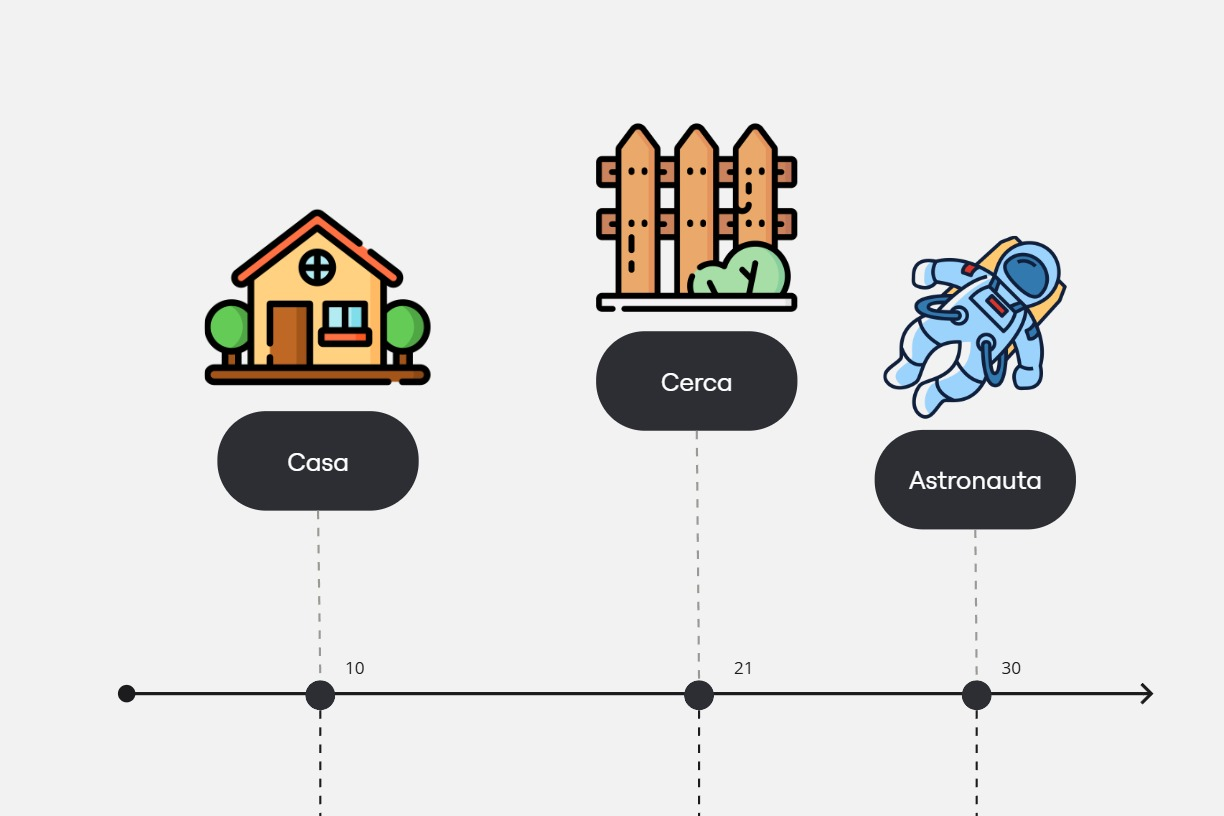

Si nos guiamos por esto, la red interpretaría que Astronauta "vale" o "es" el triple que casa, y que cerca es un poquito más del doble de casa y que es algo entre casa y astronauta; podemos ver que nada esto tiene ningún tipo de sentido. Lo que se busca es que en principio la red evalúe cada token como elementos equidistantes entre cada uno de ellos, y por eso hacemos el one hot encoding. Al hacer el One Hot encoding, nuestras palabras lucirían de la siguiente forma:

- Casa = [1, 0, 0]
- Cerca = [0, 1, 0]
- Astronauta = [0, 0, 1]

Lo que graficamente se vería de la siguiente forma

![Untitled (1).jpg](<attachment:Untitled (1).jpg>)

Evidentemente, al crear diccionarios con miles de palabras, es ineficiente trabajar con vectores tan grandes solo para representar la posición en el "espacio" de una palabra (o token). Esto lo solucionaremos comprimiendo los datos en una capa de embedding en el modelo.

Al mismo tiempo, la naturaleza del lenguaje hace que sí existan palabras relacionadas, pudiendo decir que hay palabras que sí se acercan más a unas que a otras, la capa de embedding también nos ayudará con esto.

In [1]:
VOCAB_SIZE = 100000
X_train = [one_hot(doc, VOCAB_SIZE) for doc in X_train]
X_test = [one_hot(doc, VOCAB_SIZE) for doc in X_test]

encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

class_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Mapeo de clases:", class_mapping)
print("1: Sarcasmo")
print("0: Normal")

NameError: name 'X_train' is not defined

## 4. Creación de secuencias de palabras

In [8]:
MAX_WORDS = 50
pad_corpus_train = keras.utils.pad_sequences(X_train, maxlen=MAX_WORDS, padding='post')
pad_corpus_test = keras.utils.pad_sequences(X_test, maxlen=MAX_WORDS, padding='post')

print(pad_corpus_test[0])

[36919 18899 25478 89713 96490 20396 49666 39650 99519 45504 87763 18899
  7129 51580     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


## 5. Creación del modelo

El modelo consta de 4 capas.

**1. Capa de Embedding:**

> La capa de Embedding, recibirá tantas entradas como palabras haya en el diccionario. El embedding size define la cantidad de dimensiones (o características) por las cuales se va a clasificar cada una de las palabras que entren en la red; [este conjunto de características van a otorgar la cercanía entre las palabras (clustering) para posteriormente clasificar cada uno de los textos](https://projector.tensorflow.org/).

**2. Capa LSTM:**

> La capa LSTM nos servirá se utiliza para capturar y recordar las secuencias de dato.

**3. Dropout:**

> Con esta capa conseguimos descartar aleatoreamente un porcentaje de neuronas en cada capa en cada paso del entrenamiento, obligando a no depender demasiado de ninguna neurona en particular y aprender de una forma más generalizable; esto se hace con el fin de aprender el overfitting

**4. Capa de salida**

> Se define una capa con densidad 2 ya que al ser un clasificador binario podemos tener dos posibles salidas.

In [3]:
from keras.api.layers import Dense, Dropout, LSTM, Embedding
from keras import Sequential

EMBEDDING_SIZE = 32

model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBEDDING_SIZE))
model.add(LSTM(EMBEDDING_SIZE))
model.add(Dropout(0.05))
model.add(Dense(2, activation='softmax'))
# Compilación del modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## 6. Entrenamiento

In [17]:
# Entrenamiento del modelo
history = model.fit(pad_corpus_train, y_train, epochs=32, batch_size=32, validation_data=(pad_corpus_test, y_test))


Epoch 1/32
432/432 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5644 - loss: 0.6854 - val_accuracy: 0.5755 - val_loss: 0.6817
Epoch 2/32
432/432 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.6434 - loss: 0.6382 - val_accuracy: 0.5840 - val_loss: 0.6768
Epoch 3/32
432/432 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.6138 - loss: 0.6342 - val_accuracy: 0.5755 - val_loss: 0.6754
Epoch 4/32
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5574 - loss: 0.6782 - val_accuracy: 0.5755 - val_loss: 0.6779
Epoch 5/32
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5469 - loss: 0.6800 - val_accuracy: 0.5755 - val_loss: 0.6781
Epoch 6/32
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5690 - loss: 0.6765 - val_accuracy: 0.5755 - val_loss: 0.6801
Epoch 7/32
432/432 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.5678 - loss: 0.6775 - val_accuracy: 0.5755 - val_loss: 0.6766
Epoch 8/32
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5666 - loss: 0.6793 - v

## 7. Evaluación del modelo

In [18]:
# Evaluación del modelo
loss, accuracy = model.evaluate(pad_corpus_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5809 - loss: 0.6801
Loss: 0.681706964969635, Accuracy: 0.5755185484886169


In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 50, 32)         │     3,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,625,160 (36.72 MB)

 Trainable params: 3,208,386 (12.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,416,774 (24.48 MB)

## 8. Resultados del modelo

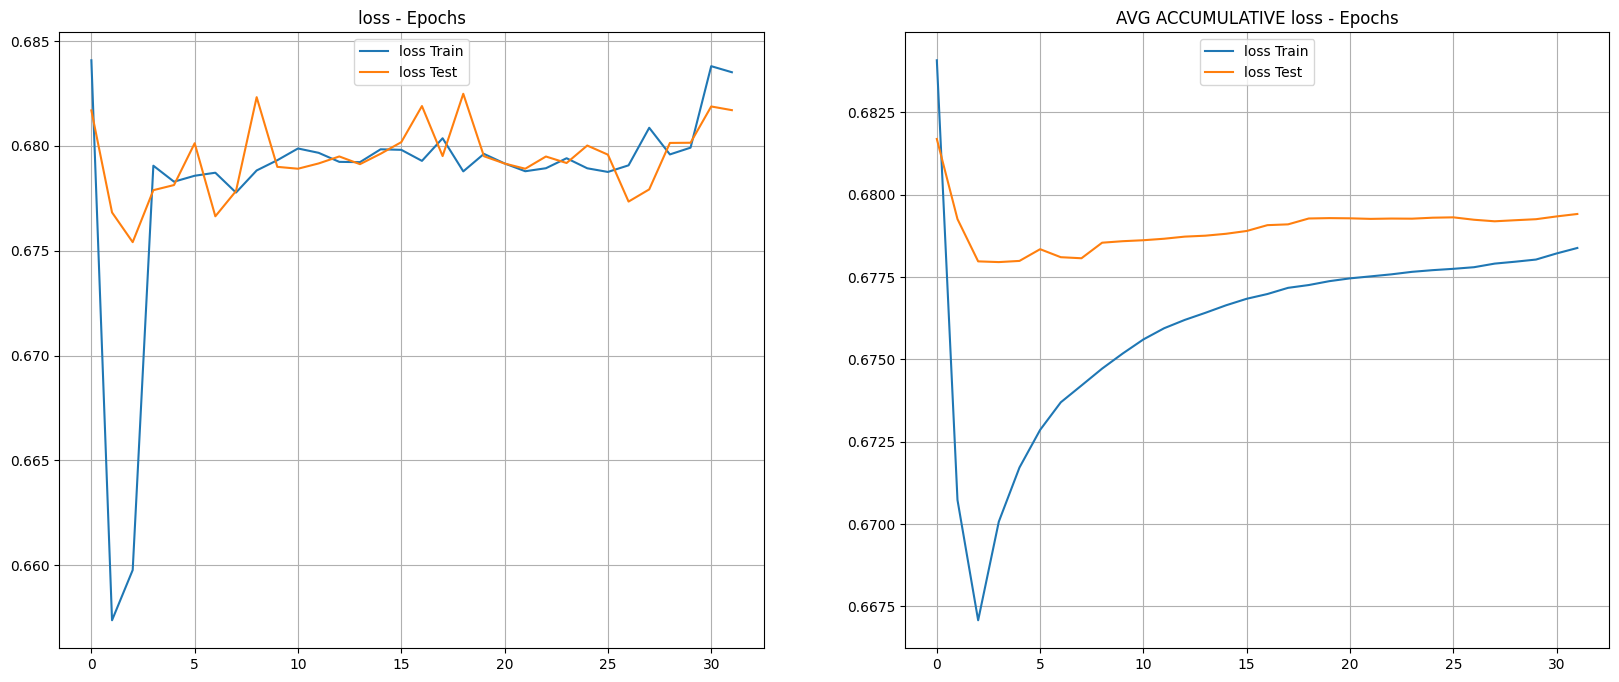

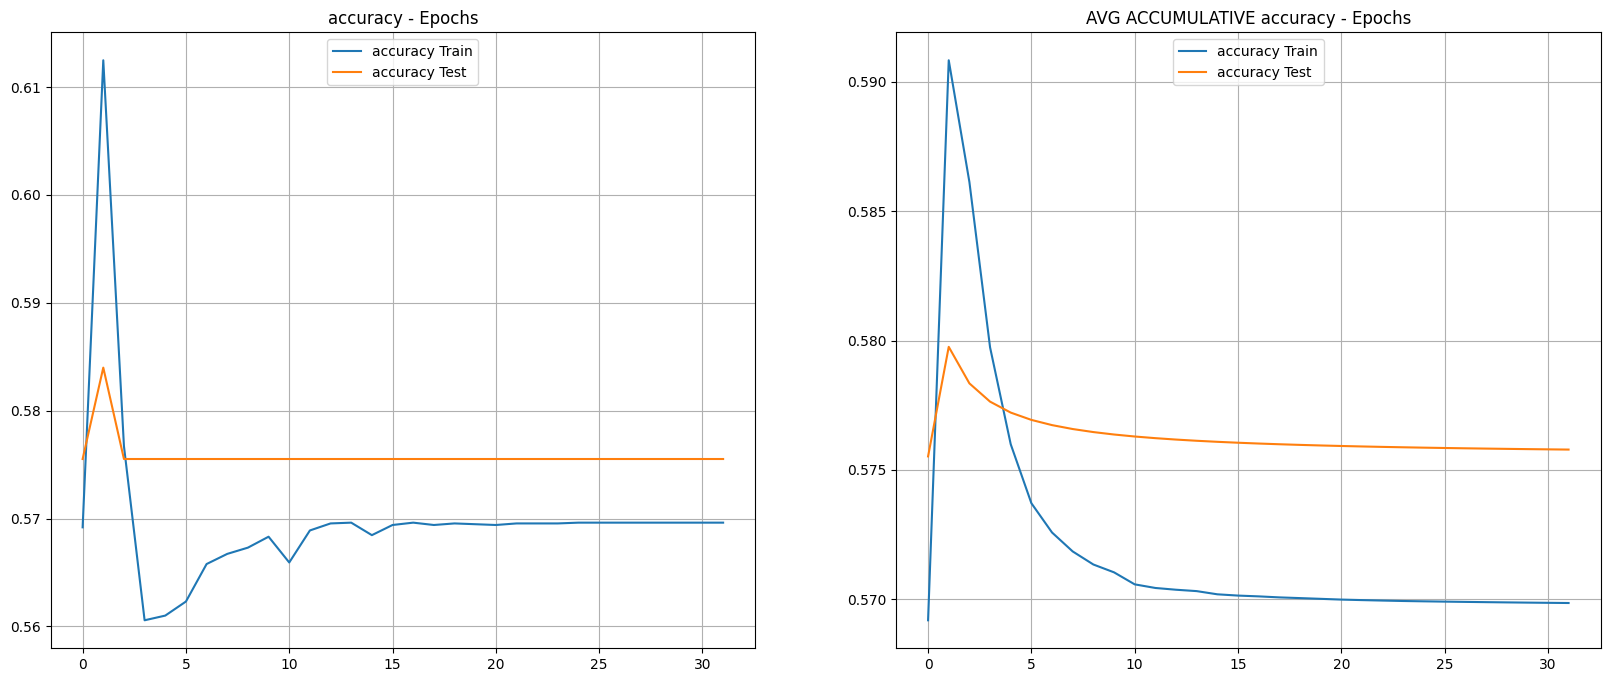

In [21]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

import matplotlib.pyplot as plt

# Pintamos las métricas por epoch
def plot_metric(history, name, remove_first=0):
    metric_train = np.array(history.history[name])[remove_first:]
    metric_test = np.array(history.history['val_{}'.format(name)])[remove_first:]
    acum_avg_metric_train = (np.cumsum(metric_train) / (np.arange(metric_train.shape[-1]) + 1))[remove_first:]
    acum_avg_metric_test = (np.cumsum(metric_test) / (np.arange(metric_test.shape[-1]) + 1))[remove_first:]
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('{} - Epochs'.format(name))
    plt.plot(metric_train, label='{} Train'.format(name))
    plt.plot(metric_test, label='{} Test'.format(name))
    plt.grid()
    plt.legend(loc='upper center')
    plt.subplot(1, 2, 2)
    plt.title('AVG ACCUMULATIVE {} - Epochs'.format(name))
    plt.plot(acum_avg_metric_train, label='{} Train'.format(name))
    plt.plot(acum_avg_metric_test, label='{} Test'.format(name))
    plt.grid()
    plt.legend(loc='upper center')
    plt.show()

# Función de perdida
plot_metric(history=history, name='loss')

# Accuracy
plot_metric(history=history, name='accuracy')